In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from utils import *
from xgboost import XGBClassifier

In [24]:
X = pd.read_csv("TrainningInput_Dataset_myseg.csv",index_col = 0)
print(X.shape)

y = pd.read_csv("TrainningOutput_Dataset_myseg.csv",index_col=0)
print(y.shape)

X_test = pd.read_csv("TestingInput_Dataset_myseg.csv",index_col=0)

# Shuffle the data
X_origin = X.sample(n=X.shape[0])
y = y.loc[X_origin.index]

# Here create other feature from the original ones. Maybe compute body surface, first i did imc but what I really wanted was like the average organ size of a patient so I took instead a measure of body area.. Then remove the feature height and weight.
add_body_surface_area_feature(X_origin)
X_origin.drop(columns=["Height", "Weight"],axis=1,inplace=True)
add_ratio_features(X_origin)

add_body_surface_area_feature(X_test)
X_test.drop(columns=["Height","Weight"],axis =1,inplace = True)
add_ratio_features(X_test)

X = augment_data(X_origin)
X = X.map(lambda x: max(0, x))# because we min max after

(100, 8)
(100, 1)
body surface are feature added modified
body surface are feature added modified


In [25]:
pipeline = Pipeline([
    ("normaliser" , MinMaxScaler()),
    ("classifier", RandomForestClassifier()),
])
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'normaliser', 'classifier', 'normaliser__clip', 'normaliser__copy', 'normaliser__feature_range', 'classifier__bootstrap', 'classifier__ccp_alpha', 'classifier__class_weight', 'classifier__criterion', 'classifier__max_depth', 'classifier__max_features', 'classifier__max_leaf_nodes', 'classifier__max_samples', 'classifier__min_impurity_decrease', 'classifier__min_samples_leaf', 'classifier__min_samples_split', 'classifier__min_weight_fraction_leaf', 'classifier__monotonic_cst', 'classifier__n_estimators', 'classifier__n_jobs', 'classifier__oob_score', 'classifier__random_state', 'classifier__verbose', 'classifier__warm_start'])

In [58]:
param_grid = {
    'classifier__n_estimators': [200,100,300],
    'classifier__max_features': ['sqrt'],
    'classifier__max_depth': [2,3,4,5],
    'classifier__min_samples_split': [2,3,4,5],
    'classifier__min_samples_leaf': [2,4],
}

In [38]:
test = []
train = []
cv_res = []
for noise_factor in [0,0.01,0.02,0.04,0.06,0.08,0.1,0.12,0.16,0.2,0.3,0.5,1]:
    train_i = []
    test_i = []
    for _ in range(10): 
        # just to have different noise each time
        X = augment_data(X_origin,noise_factor=noise_factor)
        X = X.map(lambda x: max(0, x))# because we min max after
        grid_search = GridSearchCV(pipeline,param_grid=param_grid,cv=5,verbose=1,return_train_score=True)
        grid_search.fit(X,y["Category"])

        best_params = grid_search.best_params_
        results = grid_search.cv_results_
        # Only keep the cv result for the best paramaters.
        best_idx = results['params'].index(best_params)
        mean_train_score = results['mean_train_score'][best_idx]
        mean_valid_score = results['mean_test_score'][best_idx]
        std_train_score = results['std_train_score'][best_idx]
        std_valid_score = results['std_test_score'][best_idx]
        test_i.append((mean_valid_score,std_valid_score))
        train_i.append((mean_train_score,std_train_score))

    print(f'validation : (mean : {np.mean([x[0] for x in test_i])} | std : {np.mean([x[1] for x in test_i])})')
    print(f'trainning : (mean : {np.mean([x[0] for x in train_i])} | std : {np.mean([x[1] for x in train_i])})')

    test.append((np.mean([x[0] for x in test_i]),np.mean([x[1] for x in test_i])))
    train.append((np.mean([x[0] for x in train_i]),np.mean([x[1] for x in train_i])))



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
validation : (mean : 0.9339999999999998 | std : 0.04336270760146689)
trainning : (mean : 0.9837499999999999 | std : 0.009596812455122564)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candid

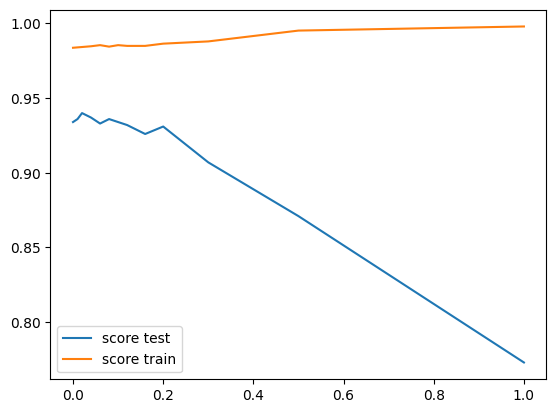

In [39]:
import matplotlib.pyplot as plt 

plt.figure()
plt.plot([0,0.01,0.02,0.04,0.06,0.08,0.1,0.12,0.16,0.2,0.3,0.5,1],[i[0] for i in test],label="score test")
plt.plot([0,0.01,0.02,0.04,0.06,0.08,0.1,0.12,0.16,0.2,0.3,0.5,1],[i[0] for i in train],label = "score train")
plt.legend()
plt.show()

In [ ]:
i = np.argmax([i[0] for i in test])
j = np.argmin([i[1] for i in test])
print(i,j)
test[i][0],test[j][1]



2 9


(np.float64(0.9399999999999997), np.float64(0.03584619420460217))

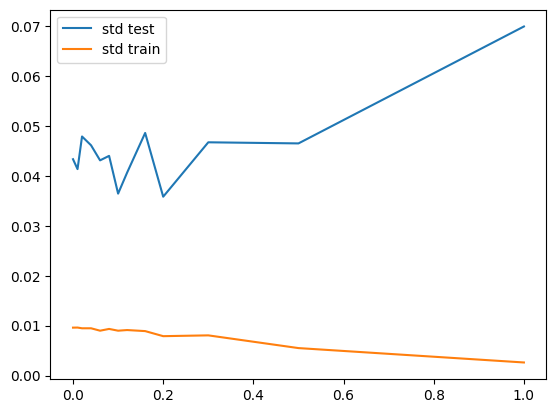

In [40]:
plt.figure()
plt.plot([0,0.01,0.02,0.04,0.06,0.08,0.1,0.12,0.16,0.2,0.3,0.5,1],[i[1] for i in test],label="std test")
plt.plot([0,0.01,0.02,0.04,0.06,0.08,0.1,0.12,0.16,0.2,0.3,0.5,1],[i[1] for i in train],label = "std train")
plt.legend()
plt.show()

In [57]:
X = augment_data(X_origin,0.02)
grid_search = GridSearchCV(pipeline,param_grid=param_grid,cv=5,verbose=3,return_train_score=True)
grid_search.fit(X,y["Category"])

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=300;, score=(train=0.988, test=1.000) total time=   1.2s
[CV 2/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=300;, score=(train=0.988, test=0.900) total time=   0.9s
[CV 3/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=300;, score=(train=0.988, test=0.950) total time=   1.3s
[CV 4/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=300;, score=(train=1.000, test=0.900) total time=   0.9s
[CV 5/5] END classifier__max_depth=5, classifier__max_features=sqrt, class

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('normaliser', MinMaxScaler()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__max_depth': [5, 10, 15],
                         'classifier__max_features': ['sqrt'],
                         'classifier__min_samples_leaf': [2, 4],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [300, 500, 1000]},
             return_train_score=True, verbose=3)

The model is fitted and now we want to properly evaluate the results. 
We select only the result from the best_params founded by the search. (Reminder that the best params are the one that provided the best mean validation score)

In [59]:
best_params = grid_search.best_params_
print(best_params)
results = grid_search.cv_results_

# Only keep the cv result for the best paramaters.
best_idx = results['params'].index(best_params)

mean_train_score = results['mean_train_score'][best_idx]
mean_valid_score = results['mean_test_score'][best_idx]
std_train_score = results['std_train_score'][best_idx]
std_valid_score = results['std_test_score'][best_idx]
print(mean_valid_score,std_valid_score)
print(mean_train_score,std_train_score)

{'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
0.95 0.04472135954999579
0.99 0.004999999999999983


In [60]:
from sklearn.metrics import confusion_matrix,accuracy_score
y_pred = grid_search.predict(X)
acc = accuracy_score(y,y_pred)
cm = confusion_matrix(y,y_pred)
print(acc)
print(cm)

0.99
[[20  0  0  0  0]
 [ 0 19  1  0  0]
 [ 0  0 20  0  0]
 [ 0  0  0 20  0]
 [ 0  0  0  0 20]]


In [61]:
submission_name = "submission_3.csv"
submission_dataframe = pd.DataFrame(columns=["Id","Category"])
submission_dataframe["Id"] = X_test.index + 101
y_test_pred = grid_search.predict(X_test)
submission_dataframe["Category"] = y_test_pred
submission_dataframe.to_csv(os.path.join(os.getcwd(),submission_name),index=False)
print("file saved")

file saved


In [10]:
print(results)

{'mean_fit_time': array([0.76203856, 1.71247926, 3.26427069, 0.82805138, 1.19350042,
       3.2025538 , 0.90829449, 1.20918026, 3.50369282, 0.81438265,
       1.40163546, 3.00726519, 1.042026  , 1.57994175, 3.22540307,
       0.68507385, 1.13012629, 2.28130589, 0.67302194, 1.58012242,
       3.23659282, 0.86957841, 1.87011776, 3.12144222, 0.77415991,
       1.53916702, 2.88883719, 0.93685827, 1.37873249, 3.06259289,
       0.69651604, 1.55076699, 4.62944484, 1.23636289, 1.45802574,
       3.00762019]), 'std_fit_time': array([0.09026809, 0.48034581, 0.47631995, 0.18642645, 0.06393448,
       0.77839699, 0.17574906, 0.08946791, 0.86242288, 0.21928354,
       0.29818783, 0.85349996, 0.16578725, 0.17942376, 0.71157396,
       0.01433779, 0.01175667, 0.07387349, 0.00844867, 0.4837908 ,
       0.27762343, 0.09575794, 0.43598282, 0.41889177, 0.08799352,
       0.23220617, 0.52416898, 0.1646383 , 0.26098696, 0.32396876,
       0.00900461, 0.25195335, 1.57991956, 0.29302948, 0.44672675,
       

In [11]:
f_importance = grid_search.best_estimator_.named_steps["classifier"].feature_importances_
f_name = grid_search.best_estimator_.named_steps["normaliser"].get_feature_names_out()
feature_importance = pd.DataFrame({
    "feature": f_name,
    "importance": f_importance
})
feature_importance.sort_values("importance", ascending=False, inplace=True)
print(feature_importance)

                          feature  importance
16  ED_LV_volume_div_ES_LV_volume    0.051196
32  ES_LV_volume_div_ED_LV_volume    0.049979
21  ED_MY_volume_div_ES_RV_volume    0.047766
28  ES_RV_volume_div_ES_LV_volume    0.042334
34  ES_LV_volume_div_ES_RV_volume    0.038680
10  ED_RV_volume_div_ES_LV_volume    0.037392
4                    ES_LV_volume    0.035887
15  ED_LV_volume_div_ES_RV_volume    0.035334
41  ES_MY_volume_div_ES_LV_volume    0.035324
33  ES_LV_volume_div_ED_MY_volume    0.035065
40  ES_MY_volume_div_ES_RV_volume    0.034745
29  ES_RV_volume_div_ES_MY_volume    0.034704
27  ES_RV_volume_div_ED_MY_volume    0.034350
35  ES_LV_volume_div_ES_MY_volume    0.033869
31  ES_LV_volume_div_ED_RV_volume    0.033409
36  ES_LV_volume_div_body_surface    0.030135
13  ED_LV_volume_div_ED_RV_volume    0.028701
26  ES_RV_volume_div_ED_LV_volume    0.028442
22  ED_MY_volume_div_ES_LV_volume    0.028029
47  body_surface_div_ES_LV_volume    0.027727
7   ED_RV_volume_div_ED_LV_volume 

Below two cells to save the results : the model and the description of the method used.

In [12]:
description = "Data augmentation + MinmaxScaler + Randomforest with Gridsearch." 
other_params = "The features are just the volume of each segmentation + body surface + all the possible ratios."
name_folder = "RF_data_aug_fixed_max_depth_high_nbtrees_"
feature_used = f_name
informationDict = {
    "description": description,
    "model parameters" : best_params,
    "features used" : feature_used,
    "mean test accuracy with best params" : mean_valid_score ,
    "std  test with best params" : std_valid_score,
    "mean train accuracy with best params" : mean_train_score,
    "std train best params" : std_train_score,
    "other parms" : other_params,
    
}

In [13]:
import joblib
from datetime import datetime
import os

# Create a timestamp
currentDateTime = datetime.now()

# Get the base directory (current directory)
BASE_DIR = os.getcwd()
print(f"BASE_DIR: {BASE_DIR}")
RESULT_DIR = os.path.join(BASE_DIR,"output")
if not os.path.exists(RESULT_DIR):
    os.mkdir(RESULT_DIR)
    print(f"Directory created: {RESULT_DIR}")

# Create a folder named 'pipeline_<timestamp>' in the current directory
dir_name = name_folder
dir_path = os.path.join(RESULT_DIR, dir_name)

# If the directory doesn't exist, create it
if not os.path.exists(dir_path):
    os.mkdir(dir_path)
    print(f"Directory created: {dir_path}")

# Save the model inside this new folder
model_filename = 'pipeline_' + currentDateTime.strftime("%H-%M-%S") + '.pkl'
model_path = os.path.join(dir_path, model_filename)

# This is where you'd have your model defined
joblib.dump(grid_search, model_path)
print(f"Model saved to: {model_path}")


# Saving feature importance : 
feature_importance_filename ='pipeline_' + currentDateTime.strftime("%H-%M-%S") + '.csv' 
feature_importance_dir = os.path.join(dir_path,feature_importance_filename)
feature_importance.to_csv(feature_importance_dir)


# SAVING Description 
dict_filename = 'params.txt'
dict_path = os.path.join(dir_path, dict_filename)

with open(dict_path, 'w') as f:
    for key, val in informationDict.items():
        f.write(f"{key} : {val}\n")
print(f"Information about the model saved to: {dict_path}")


BASE_DIR: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction
Model saved to: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/output/RF_data_aug_fixed_max_depth_high_nbtrees_/pipeline_17-29-06.pkl
Information about the model saved to: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/output/RF_data_aug_fixed_max_depth_high_nbtrees_/params.txt
